In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [2]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

9913344it [00:00, 16153418.78it/s]                             


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



29696it [00:00, 29698152.50it/s]         


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



1649664it [00:00, 23566731.31it/s]         


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



5120it [00:00, 5115492.25it/s]          


Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


C:\Users\joste\anaconda3\envs\tdt4195\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Conv2d(1, 32, 5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(64, 128, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(4*4*128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [12]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [13]:
# Hyperparameters
learning_rate = .02
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [14]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:20<00:00, 44.98it/s]


# Task 2a

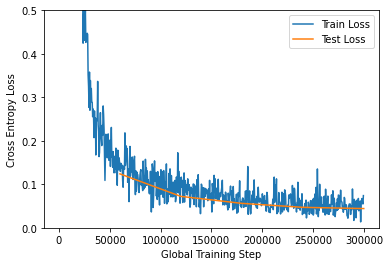

Final Test loss: 0.0442556838694423. Final Test accuracy: 0.9854


In [15]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .5])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2a_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

# Task 2b

In [27]:
modelB = create_model()

# Hyperparameters
learning_rateB = .001


optimizerB = torch.optim.Adam(modelB.parameters(),
                            lr=learning_rateB)


In [28]:
trainerB = Trainer(
  model=modelB,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizerB
)
train_loss_dictB, test_loss_dictB = trainerB.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:25<00:00, 37.14it/s]


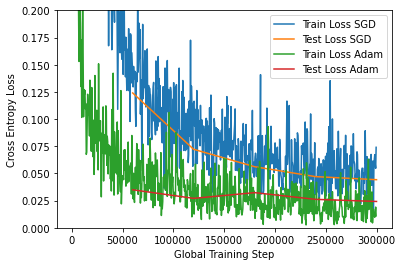

Final Test loss B: 0.024232809145586006. Final Test accuracy: 0.9927


In [33]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss SGD")
utils.plot_loss(test_loss_dict, label="Test Loss SGD")
utils.plot_loss(train_loss_dictB, label="Train Loss Adam")
utils.plot_loss(test_loss_dictB, label="Test Loss Adam")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .2])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2b_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, modelB, loss_function)
print(f"Final Test loss B: {final_loss}. Final Test accuracy: {final_acc}")